In [120]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [121]:
dim = 64
with h5py.File("life_64.h5", "r") as f:
    X = f["X"][:20] # shape (20,64,64), dtype=uint8
    y = f["Y"][:20]

X = np.array(X)
y = np.array(y)

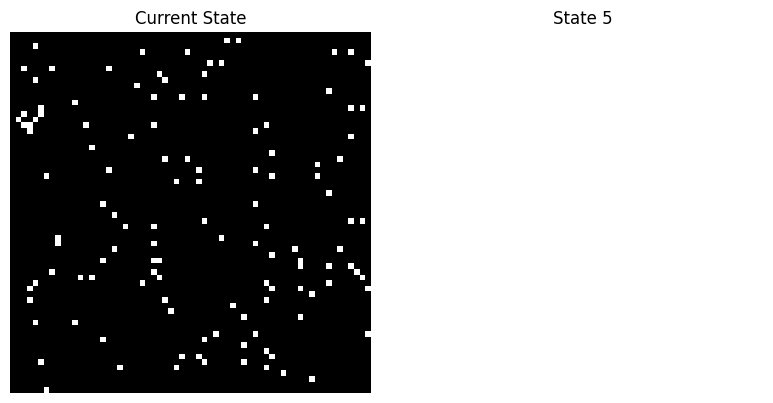

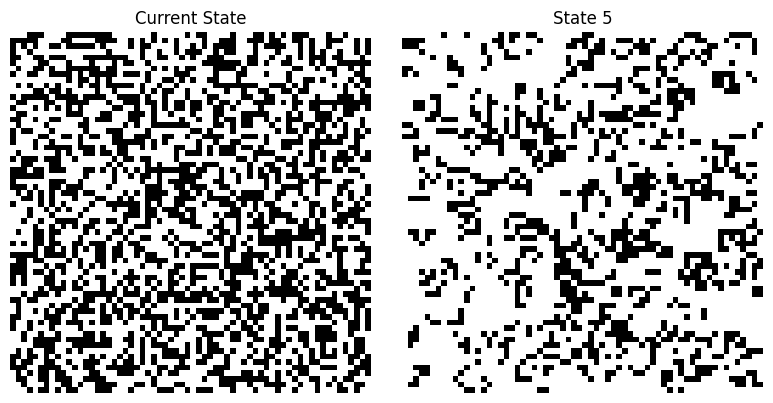

In [122]:
from torch.utils.data import TensorDataset, DataLoader

for i in range(min(2, X.shape[0])):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(X[i], cmap="binary", interpolation="nearest")
    axes[0].set_title("Current State")
    axes[1].imshow(y[i], cmap="binary", interpolation="nearest")
    axes[1].set_title("State 5")

    for ax in axes:
        ax.axis("off")   # hide grid and ticks

    plt.tight_layout()
    plt.show()

In [123]:
import torch
import torch.nn as nn

class Life_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 1, 1)
        )

    
    def forward(self, x):
        return self.net(x)

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32).unsqueeze(1)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)

In [125]:
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = Life_CNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [126]:
num_epochs = 5000

In [127]:
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch:03d}  avg loss = {running_loss/len(train_loader):.4f}")

Epoch 001  avg loss = 0.7577
Epoch 002  avg loss = 0.6891
Epoch 003  avg loss = 0.5728
Epoch 004  avg loss = 0.4245
Epoch 005  avg loss = 0.3045
Epoch 006  avg loss = 0.2650
Epoch 007  avg loss = 0.2774
Epoch 008  avg loss = 0.2891
Epoch 009  avg loss = 0.2841
Epoch 010  avg loss = 0.2707
Epoch 011  avg loss = 0.2635
Epoch 012  avg loss = 0.2630
Epoch 013  avg loss = 0.2629
Epoch 014  avg loss = 0.2622
Epoch 015  avg loss = 0.2605
Epoch 016  avg loss = 0.2592
Epoch 017  avg loss = 0.2592
Epoch 018  avg loss = 0.2577
Epoch 019  avg loss = 0.2566
Epoch 020  avg loss = 0.2577
Epoch 021  avg loss = 0.2547
Epoch 022  avg loss = 0.2542
Epoch 023  avg loss = 0.2529
Epoch 024  avg loss = 0.2520
Epoch 025  avg loss = 0.2511
Epoch 026  avg loss = 0.2506
Epoch 027  avg loss = 0.2491
Epoch 028  avg loss = 0.2479
Epoch 029  avg loss = 0.2472
Epoch 030  avg loss = 0.2452
Epoch 031  avg loss = 0.2443
Epoch 032  avg loss = 0.2421
Epoch 033  avg loss = 0.2401
Epoch 034  avg loss = 0.2385
Epoch 035  avg

In [128]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)                   # (B,1,64,64)
            loss   = criterion(logits, masks)      # BCEWithLogitsLoss
            total_loss += loss.item() * imgs.size(0)

            probs = torch.sigmoid(logits)          # (B,1,64,64)
            preds = (probs > 0.5).float()          # binarize

            # pixel‐wise accuracy
            correct_pixels += (preds == masks).sum().item()
            total_pixels   += torch.numel(preds)

    avg_loss = total_loss / len(val_loader.dataset)
    pixel_acc = correct_pixels / total_pixels

    print(f"Validation — avg loss: {avg_loss:.4f}, pixel accuracy: {pixel_acc:.4%}")
    return avg_loss, pixel_acc

In [129]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)

Validation — avg loss: 0.8220, pixel accuracy: 80.7678%


In [130]:
def plot_predictions(model, loader, device, n_images=4):
    model.eval()
    # grab one batch
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    
    with torch.no_grad():
        logits = model(imgs)                # (B,1,64,64)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()      # binarize
    
    imgs  = imgs.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    for i in range(min(n_images, imgs.size(0))):
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
        
        axes[0].imshow(imgs[i,0], cmap="binary", interpolation="nearest")
        axes[0].set_title("Input State")
        
        axes[1].imshow(masks[i,0], cmap="binary", interpolation="nearest")
        axes[1].set_title("True Next State")
        
        axes[2].imshow(preds[i,0], cmap="binary", interpolation="nearest")
        axes[2].set_title("Predicted Next State")
        
        for ax in axes:
            ax.axis("off")
        
        plt.tight_layout()
        plt.show()

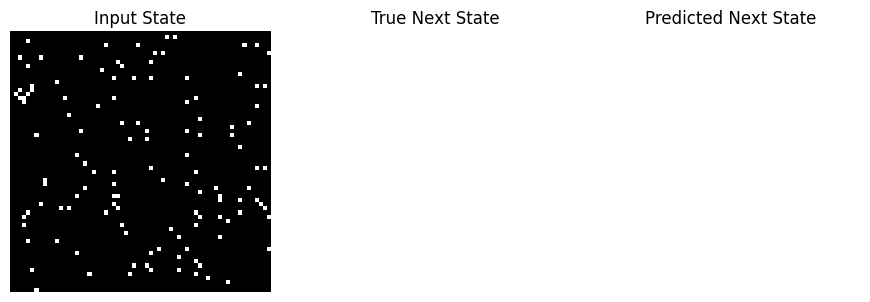

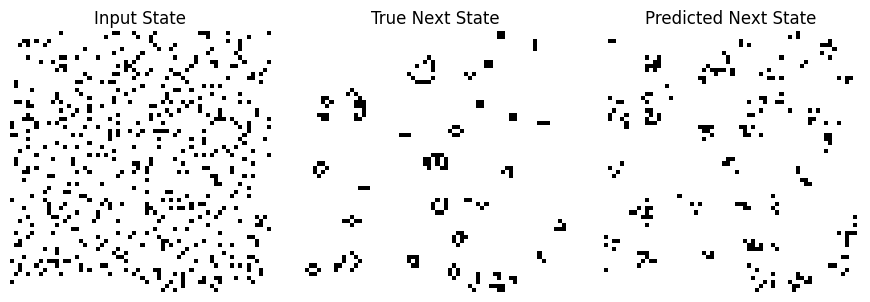

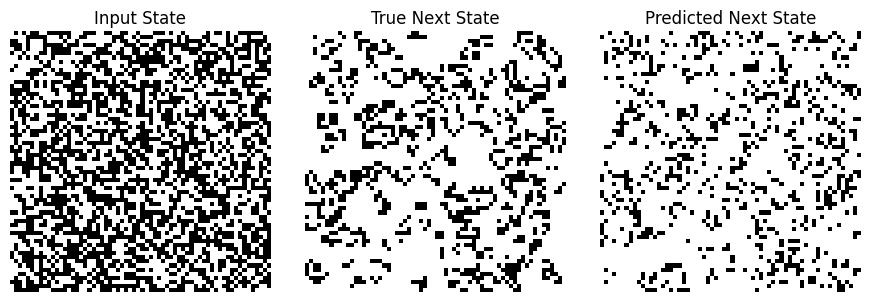

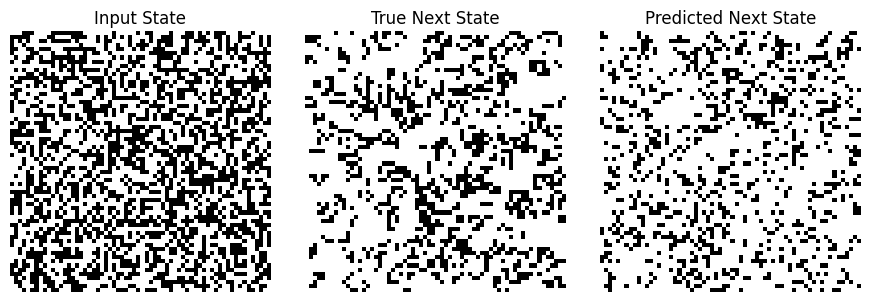

In [132]:
plot_predictions(model, val_loader, device, n_images=15)
